<a href="https://colab.research.google.com/github/mchirico/COVID-19/blob/master/COVID_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**COVID-19**

Note:  You need to make a copy of this note book, if you want to run it yourself
by clicking on "File/Save a copy in Drive"



Sharable link:
https://colab.research.google.com/drive/1RZXskxLFGTMcw7Q88VwIWk7vSceGbIkf







Data From: 
[JHU CSSE](https://github.com/CSSEGISandData/COVID-19)



In [1]:
import requests
import pandas as pd
import numpy as np 
from datetime import datetime



import warnings
warnings.filterwarnings("ignore")

try:
  import seaborn as sns
  import matplotlib.pyplot as plt
  import matplotlib.dates as mdates
  sns.set(style="white", color_codes=True)
  from matplotlib_venn import venn2
  import keras
  import pydot
  import libarchive
  import torch
except:
  print("Will try to install software")
  # Lines below .... Only need to be run once at the top of the notebook.
  !pip install -q matplotlib-venn
  !pip install -q keras
  # #   https://pypi.python.org/pypi/pydot
  !apt-get -qq install -y graphviz && pip install -q pydot
  !apt-get -qq install -y libarchive-dev && pip install -q -U libarchive
  !pip install -U -q PyDrive
  !pip install --upgrade -q gspread
  
  !pip install torchvision
  
  import seaborn as sns
  import matplotlib.pyplot as plt
  import matplotlib.dates as mdates
  sns.set(style="white", color_codes=True)
  from matplotlib_venn import venn2
  import keras
  import pydot
  import libarchive





Using TensorFlow backend.


Will try to install software
Selecting previously unselected package libarchive-dev:amd64.
(Reading database ... 133872 files and directories currently installed.)
Preparing to unpack .../libarchive-dev_3.2.2-3.1ubuntu0.6_amd64.deb ...
Unpacking libarchive-dev:amd64 (3.2.2-3.1ubuntu0.6) ...
Setting up libarchive-dev:amd64 (3.2.2-3.1ubuntu0.6) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
     |████████████████████████████████| 163kB 7.5MB/s 


## Reading in the data..

#### Read in Confirmed Cases

In [89]:
url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
d=pd.read_csv(url)
d.head()

# US counted twice: 1) County 2) State
# c = d[(d['Country/Region']=='US') & (d['Province/State'].str.contains(','))]

c = d[(d['Country/Region']=='US') & (~d['Province/State'].str.contains(',', na=False)) ]
cols = d.columns[0:1].tolist() + d.columns[4::].tolist()



c=c[cols]
c=c.set_index('Province/State')
c.diff(axis=1)

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20
Province/State,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Washington,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,267.0,99.0,76.0,126.0,4.0,71.0,261.0,172.0,-62.0
New York,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,173.0,47.0,108.0,93.0,104.0,207.0,235.0,739.0,789.0
California,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,144.0,33.0,44.0,61.0,58.0,86.0,131.0,141.0,53.0
Massachusetts,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,92.0,3.0,13.0,15.0,15.0,26.0,33.0,21.0,0.0
Diamond Princess,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,6.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Grand Princess,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0
Georgia,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,6.0,8.0,11.0,24.0,33.0,22.0,25.0,53.0
Colorado,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,19.0,11.0,4.0,52.0,30.0,29.0,0.0,24.0
Florida,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,13.0,7.0,15.0,26.0,39.0,40.0,61.0,98.0


['1/22/20',
 '1/23/20',
 '1/24/20',
 '1/25/20',
 '1/26/20',
 '1/27/20',
 '1/28/20',
 '1/29/20',
 '1/30/20',
 '1/31/20',
 '2/1/20',
 '2/2/20',
 '2/3/20',
 '2/4/20',
 '2/5/20',
 '2/6/20',
 '2/7/20',
 '2/8/20',
 '2/9/20',
 '2/10/20',
 '2/11/20',
 '2/12/20',
 '2/13/20',
 '2/14/20',
 '2/15/20',
 '2/16/20',
 '2/17/20',
 '2/18/20',
 '2/19/20',
 '2/20/20',
 '2/21/20',
 '2/22/20',
 '2/23/20',
 '2/24/20',
 '2/25/20',
 '2/26/20',
 '2/27/20',
 '2/28/20',
 '2/29/20',
 '3/1/20',
 '3/2/20',
 '3/3/20',
 '3/4/20',
 '3/5/20',
 '3/6/20',
 '3/7/20',
 '3/8/20',
 '3/9/20',
 '3/10/20',
 '3/11/20',
 '3/12/20',
 '3/13/20',
 '3/14/20',
 '3/15/20',
 '3/16/20',
 '3/17/20',
 '3/18/20']

In [58]:
c[d.columns[-10::].tolist()].diff(axis = 1)

,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20
98,NaN,267.0,99.0,76.0,126.0,4.0,71.0,261.0,172.0,-62.0
99,NaN,173.0,47.0,108.0,93.0,104.0,207.0,235.0,739.0,789.0
100,NaN,144.0,33.0,44.0,61.0,58.0,86.0,131.0,141.0,53.0
101,NaN,92.0,3.0,13.0,15.0,15.0,26.0,33.0,21.0,0.0
102,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
103,NaN,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0
104,NaN,17.0,6.0,8.0,11.0,24.0,33.0,22.0,25.0,53.0
105,NaN,15.0,19.0,11.0,4.0,52.0,30.0,29.0,0.0,24.0
106,NaN,15.0,13.0,7.0,15.0,26.0,39.0,40.0,61.0,98.0
107,NaN,15.0,8.0,6.0,0.0,40.0,29.0,80.0,89.0,0.0


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20
98,Washington,US,47.4009,-121.4905,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,267,366,442,568,572,643,904,1076,1014
99,New York,US,42.1657,-74.9481,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,173,220,328,421,525,732,967,1706,2495
100,California,US,36.1162,-119.6816,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,144,177,221,282,340,426,557,698,751
101,Massachusetts,US,42.2302,-71.5301,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,92,95,108,123,138,164,197,218,218
102,Diamond Princess,US,35.4437,139.6380,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36,36,42,42,44,44,44,45,45,45,45,45,45,45,45,46,46,46,46,46,46,47,47,47
103,Grand Princess,US,37.6489,-122.6655,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,21,21,21,21,21,21,21,21,20,21,21
104,Georgia,US,33.0406,-83.6431,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,23,31,42,66,99,121,146,199
105,Colorado,US,39.0598,-105.3111,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,34,45,49,101,131,160,160,184
106,Florida,US,27.7663,-81.6868,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,28,35,50,76,115,155,216,314
107,New Jersey,US,40.2989,-74.5210,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,23,29,29,69,98,178,267,267


In [3]:
# Deaths
url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
dt=pd.read_csv(url)
dt.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20
0,NaN,Thailand,15.0000,101.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,NaN,Japan,36.0000,138.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,2,4,4,5,6,6,6,6,6,6,6,6,10,10,15,16,19,22,22,27,29,29
2,NaN,Singapore,1.2833,103.8333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,NaN,Nepal,28.1667,84.2500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,NaN,Malaysia,2.5000,112.5000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2


In [4]:
# Recovered
url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
dr=pd.read_csv(url)
dr.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20
0,NaN,Thailand,15.0000,101.0000,0,0,0,0,2,2,5,5,5,5,5,5,5,5,5,5,5,10,10,10,10,10,12,12,12,14,15,15,15,15,17,17,21,21,22,22,22,28,28,28,31,31,31,31,31,31,31,31,33,34,34,35,35,35,35,41,42
1,NaN,Japan,36.0000,138.0000,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,9,9,9,9,12,12,12,13,18,18,22,22,22,22,22,22,22,22,32,32,32,43,43,43,46,76,76,76,101,118,118,118,118,118,144,144,144
2,NaN,Singapore,1.2833,103.8333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,9,15,15,17,18,18,24,29,34,34,37,37,51,51,53,62,62,62,72,72,78,78,78,78,78,78,78,78,78,96,96,97,105,105,109,114,114
3,NaN,Nepal,28.1667,84.2500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,3,3,3,3,7,7,7,13,15,15,15,15,15,18,18,18,18,18,18,18,18,22,22,22,22,23,24,24,24,26,26,26,35,42,42,49,60


In [5]:
# Confirmed
m=pd.melt(d, id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], value_vars=d.columns[4::])
m.columns = ['Province/State', 'Country/Region', 'Lat', 'Long', 'timeStamp', 'value']
m['timeStamp'] = m['timeStamp'].apply(lambda x: datetime.strptime(x,'%m/%d/%y'))
m.head()

,Province/State,Country/Region,Lat,Long,timeStamp,value
0,NaN,Thailand,15.0000,101.0000,2020-01-22,2
1,NaN,Japan,36.0000,138.0000,2020-01-22,2
2,NaN,Singapore,1.2833,103.8333,2020-01-22,0
3,NaN,Nepal,28.1667,84.2500,2020-01-22,0
4,NaN,Malaysia,2.5000,112.5000,2020-01-22,0


In [6]:
# deaths
mt=pd.melt(dt, id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], value_vars=d.columns[4::])
mt.columns = ['Province/State', 'Country/Region', 'Lat', 'Long', 'timeStamp', 'value']
mt['timeStamp'] = mt['timeStamp'].apply(lambda x: datetime.strptime(x,'%m/%d/%y'))
mt.head()

,Province/State,Country/Region,Lat,Long,timeStamp,value
0,NaN,Thailand,15.0000,101.0000,2020-01-22,0
1,NaN,Japan,36.0000,138.0000,2020-01-22,0
2,NaN,Singapore,1.2833,103.8333,2020-01-22,0
3,NaN,Nepal,28.1667,84.2500,2020-01-22,0
4,NaN,Malaysia,2.5000,112.5000,2020-01-22,0


In [7]:
# Recovered
mr=pd.melt(dr, id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], value_vars=d.columns[4::])
mr.columns = ['Province/State', 'Country/Region', 'Lat', 'Long', 'timeStamp', 'value']
mr['timeStamp'] = mr['timeStamp'].apply(lambda x: datetime.strptime(x,'%m/%d/%y'))
mr.head()

,Province/State,Country/Region,Lat,Long,timeStamp,value
0,NaN,Thailand,15.0000,101.0000,2020-01-22,0
1,NaN,Japan,36.0000,138.0000,2020-01-22,0
2,NaN,Singapore,1.2833,103.8333,2020-01-22,0
3,NaN,Nepal,28.1667,84.2500,2020-01-22,0
4,NaN,Malaysia,2.5000,112.5000,2020-01-22,0


## Summary Tables

In [8]:
n=pd.pivot_table(m, values='value', index=['Province/State', 'Country/Region', 'Lat', 'Long'],
                    columns=['timeStamp'], aggfunc=np.sum)
ns=pd.pivot_table(m, values='value', index=['Country/Region'],
                    columns=['timeStamp'], aggfunc=np.sum)
ns = ns.diff(axis=1)
ns=ns.reset_index()

ns[ns['Country/Region']=='US'].head()
t = pd.pivot_table(m, values='value', index=['Country/Region'],
                    columns=['timeStamp'], aggfunc=np.sum)
t = t.reset_index()
t[t['Country/Region']=='US']

timeStamp,Country/Region,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-25 00:00:00,2020-01-26 00:00:00,2020-01-27 00:00:00,2020-01-28 00:00:00,2020-01-29 00:00:00,2020-01-30 00:00:00,2020-01-31 00:00:00,2020-02-01 00:00:00,2020-02-02 00:00:00,2020-02-03 00:00:00,2020-02-04 00:00:00,2020-02-05 00:00:00,2020-02-06 00:00:00,2020-02-07 00:00:00,2020-02-08 00:00:00,2020-02-09 00:00:00,2020-02-10 00:00:00,2020-02-11 00:00:00,2020-02-12 00:00:00,2020-02-13 00:00:00,2020-02-14 00:00:00,2020-02-15 00:00:00,2020-02-16 00:00:00,2020-02-17 00:00:00,2020-02-18 00:00:00,2020-02-19 00:00:00,2020-02-20 00:00:00,2020-02-21 00:00:00,2020-02-22 00:00:00,2020-02-23 00:00:00,2020-02-24 00:00:00,2020-02-25 00:00:00,2020-02-26 00:00:00,2020-02-27 00:00:00,2020-02-28 00:00:00,2020-02-29 00:00:00,2020-03-01 00:00:00,2020-03-02 00:00:00,2020-03-03 00:00:00,2020-03-04 00:00:00,2020-03-05 00:00:00,2020-03-06 00:00:00,2020-03-07 00:00:00,2020-03-08 00:00:00,2020-03-09 00:00:00,2020-03-10 00:00:00,2020-03-11 00:00:00,2020-03-12 00:00:00,2020-03-13 00:00:00,2020-03-14 00:00:00,2020-03-15 00:00:00,2020-03-16 00:00:00,2020-03-17 00:00:00,2020-03-18 00:00:00
143,US,1,1,2,2,5,5,5,5,5,7,8,8,11,11,11,11,11,11,11,11,12,12,13,13,13,13,13,13,13,13,15,15,15,51,51,57,58,60,68,74,98,118,149,217,262,402,518,583,959,1281,1663,2179,2727,3499,4632,6421,7783


In [9]:
# We both 'Province/State', 'Country/Region'
# Careful, data counted twice
n=pd.pivot_table(m, values='value', index=['Province/State', 'Country/Region', 'Lat', 'Long'],
                    columns=['timeStamp'], aggfunc=np.sum)
nsc=pd.pivot_table(m, values='value', index=['Province/State','Country/Region'],
                    columns=['timeStamp'], aggfunc=np.sum)
nsc = nsc.diff(axis=1)
nsc=nsc.reset_index()

nsc[nsc['Country/Region']=='US'].head()
t = pd.pivot_table(m, values='value', index=['Province/State', 'Country/Region'],
                    columns=['timeStamp'], aggfunc=np.sum)
t = t.reset_index()
t[t['Country/Region']=='US']

nsc

timeStamp,Province/State,Country/Region,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-25 00:00:00,2020-01-26 00:00:00,2020-01-27 00:00:00,2020-01-28 00:00:00,2020-01-29 00:00:00,2020-01-30 00:00:00,2020-01-31 00:00:00,2020-02-01 00:00:00,2020-02-02 00:00:00,2020-02-03 00:00:00,2020-02-04 00:00:00,2020-02-05 00:00:00,2020-02-06 00:00:00,2020-02-07 00:00:00,2020-02-08 00:00:00,2020-02-09 00:00:00,2020-02-10 00:00:00,2020-02-11 00:00:00,2020-02-12 00:00:00,2020-02-13 00:00:00,2020-02-14 00:00:00,2020-02-15 00:00:00,2020-02-16 00:00:00,2020-02-17 00:00:00,2020-02-18 00:00:00,2020-02-19 00:00:00,2020-02-20 00:00:00,2020-02-21 00:00:00,2020-02-22 00:00:00,2020-02-23 00:00:00,2020-02-24 00:00:00,2020-02-25 00:00:00,2020-02-26 00:00:00,2020-02-27 00:00:00,2020-02-28 00:00:00,2020-02-29 00:00:00,2020-03-01 00:00:00,2020-03-02 00:00:00,2020-03-03 00:00:00,2020-03-04 00:00:00,2020-03-05 00:00:00,2020-03-06 00:00:00,2020-03-07 00:00:00,2020-03-08 00:00:00,2020-03-09 00:00:00,2020-03-10 00:00:00,2020-03-11 00:00:00,2020-03-12 00:00:00,2020-03-13 00:00:00,2020-03-14 00:00:00,2020-03-15 00:00:00,2020-03-16 00:00:00,2020-03-17 00:00:00,2020-03-18 00:00:00
0,"Adams, IN",US,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Alabama,US,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,6.0,17.0,10.0,7.0
2,"Alachua, FL",US,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"Alameda County, CA",US,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Alaska,US,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,Wyoming,US,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,8.0,4.0
315,Xinjiang,China,NaN,2.0,0.0,1.0,1.0,1.0,5.0,3.0,1.0,3.0,1.0,3.0,3.0,5.0,3.0,4.0,3.0,3.0,3.0,4.0,6.0,4.0,4.0,2.0,5.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
316,"Yolo County, CA",US,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
317,Yunnan,China,NaN,1.0,3.0,6.0,5.0,10.0,18.0,11.0,15.0,13.0,10.0,12.0,12.0,5.0,6.0,5.0,5.0,0.0,3.0,8.0,4.0,1.0,2.0,6.0,6.0,3.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0


In [10]:
# Deaths
nt=pd.pivot_table(mt, values='value', index=['Province/State', 'Country/Region', 'Lat', 'Long'],
                    columns=['timeStamp'], aggfunc=np.sum)
nst=pd.pivot_table(mt, values='value', index=['Country/Region'],
                    columns=['timeStamp'], aggfunc=np.sum)
nst = nst.diff(axis=1)
nst=nst.reset_index()
nst.columns
nst[nst[nst.columns[44]]>0]

timeStamp,Country/Region,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-25 00:00:00,2020-01-26 00:00:00,2020-01-27 00:00:00,2020-01-28 00:00:00,2020-01-29 00:00:00,2020-01-30 00:00:00,2020-01-31 00:00:00,2020-02-01 00:00:00,2020-02-02 00:00:00,2020-02-03 00:00:00,2020-02-04 00:00:00,2020-02-05 00:00:00,2020-02-06 00:00:00,2020-02-07 00:00:00,2020-02-08 00:00:00,2020-02-09 00:00:00,2020-02-10 00:00:00,2020-02-11 00:00:00,2020-02-12 00:00:00,2020-02-13 00:00:00,2020-02-14 00:00:00,2020-02-15 00:00:00,2020-02-16 00:00:00,2020-02-17 00:00:00,2020-02-18 00:00:00,2020-02-19 00:00:00,2020-02-20 00:00:00,2020-02-21 00:00:00,2020-02-22 00:00:00,2020-02-23 00:00:00,2020-02-24 00:00:00,2020-02-25 00:00:00,2020-02-26 00:00:00,2020-02-27 00:00:00,2020-02-28 00:00:00,2020-02-29 00:00:00,2020-03-01 00:00:00,2020-03-02 00:00:00,2020-03-03 00:00:00,2020-03-04 00:00:00,2020-03-05 00:00:00,2020-03-06 00:00:00,2020-03-07 00:00:00,2020-03-08 00:00:00,2020-03-09 00:00:00,2020-03-10 00:00:00,2020-03-11 00:00:00,2020-03-12 00:00:00,2020-03-13 00:00:00,2020-03-14 00:00:00,2020-03-15 00:00:00,2020-03-16 00:00:00,2020-03-17 00:00:00,2020-03-18 00:00:00
28,China,NaN,1.0,8.0,16.0,14.0,26.0,49.0,2.0,38.0,42.0,46.0,102.0,64.0,66.0,72.0,70.0,85.0,87.0,100.0,107.0,100.0,5.0,252.0,152.0,142.0,103.0,98.0,139.0,113.0,122.0,0.0,205.0,2.0,150.0,70.0,52.0,29.0,44.0,47.0,35.0,42.0,33.0,36.0,32.0,29.0,28.0,28.0,23.0,16.0,22.0,11.0,8.0,13.0,10.0,14.0,13.0,11.0
49,France,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,3.0,2.0,8.0,0.0,14.0,15.0,0.0,31.0,12.0,0.0,57.0,0.0,0.0
66,Iran,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,1.0,3.0,4.0,4.0,3.0,7.0,8.0,9.0,11.0,12.0,11.0,15.0,15.0,17.0,21.0,49.0,43.0,54.0,63.0,75.0,85.0,97.0,113.0,129.0,135.0,147.0
70,Italy,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,4.0,3.0,2.0,5.0,4.0,8.0,5.0,18.0,27.0,28.0,41.0,49.0,36.0,133.0,97.0,168.0,196.0,0.0,439.0,175.0,368.0,349.0,345.0,475.0
129,Spain,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,5.0,7.0,11.0,7.0,19.0,1.0,78.0,62.0,94.0,53.0,191.0,90.0
134,Switzerland,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,7.0,2.0,1.0,0.0,13.0,1.0
143,US,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,1.0,4.0,1.0,2.0,3.0,4.0,1.0,6.0,8.0,4.0,7.0,7.0,9.0,22.0,23.0,10.0
146,United Kingdom,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,13.0,0.0,35.0,0.0,16.0


In [11]:

ns.head()

timeStamp,Country/Region,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-25 00:00:00,2020-01-26 00:00:00,2020-01-27 00:00:00,2020-01-28 00:00:00,2020-01-29 00:00:00,2020-01-30 00:00:00,2020-01-31 00:00:00,2020-02-01 00:00:00,2020-02-02 00:00:00,2020-02-03 00:00:00,2020-02-04 00:00:00,2020-02-05 00:00:00,2020-02-06 00:00:00,2020-02-07 00:00:00,2020-02-08 00:00:00,2020-02-09 00:00:00,2020-02-10 00:00:00,2020-02-11 00:00:00,2020-02-12 00:00:00,2020-02-13 00:00:00,2020-02-14 00:00:00,2020-02-15 00:00:00,2020-02-16 00:00:00,2020-02-17 00:00:00,2020-02-18 00:00:00,2020-02-19 00:00:00,2020-02-20 00:00:00,2020-02-21 00:00:00,2020-02-22 00:00:00,2020-02-23 00:00:00,2020-02-24 00:00:00,2020-02-25 00:00:00,2020-02-26 00:00:00,2020-02-27 00:00:00,2020-02-28 00:00:00,2020-02-29 00:00:00,2020-03-01 00:00:00,2020-03-02 00:00:00,2020-03-03 00:00:00,2020-03-04 00:00:00,2020-03-05 00:00:00,2020-03-06 00:00:00,2020-03-07 00:00:00,2020-03-08 00:00:00,2020-03-09 00:00:00,2020-03-10 00:00:00,2020-03-11 00:00:00,2020-03-12 00:00:00,2020-03-13 00:00:00,2020-03-14 00:00:00,2020-03-15 00:00:00,2020-03-16 00:00:00,2020-03-17 00:00:00,2020-03-18 00:00:00
0,Afghanistan,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,2.0,0.0,0.0,4.0,5.0,5.0,1.0,0.0
1,Albania,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,8.0,2.0,11.0,10.0,5.0,4.0,9.0,4.0,4.0
2,Algeria,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,7.0,0.0,5.0,0.0,2.0,1.0,0.0,0.0,4.0,2.0,11.0,11.0,6.0,6.0,14.0
3,Andorra,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,37.0,0.0
4,Antigua and Barbuda,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [12]:
ns[ns['Country/Region']=='US']

timeStamp,Country/Region,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-25 00:00:00,2020-01-26 00:00:00,2020-01-27 00:00:00,2020-01-28 00:00:00,2020-01-29 00:00:00,2020-01-30 00:00:00,2020-01-31 00:00:00,2020-02-01 00:00:00,2020-02-02 00:00:00,2020-02-03 00:00:00,2020-02-04 00:00:00,2020-02-05 00:00:00,2020-02-06 00:00:00,2020-02-07 00:00:00,2020-02-08 00:00:00,2020-02-09 00:00:00,2020-02-10 00:00:00,2020-02-11 00:00:00,2020-02-12 00:00:00,2020-02-13 00:00:00,2020-02-14 00:00:00,2020-02-15 00:00:00,2020-02-16 00:00:00,2020-02-17 00:00:00,2020-02-18 00:00:00,2020-02-19 00:00:00,2020-02-20 00:00:00,2020-02-21 00:00:00,2020-02-22 00:00:00,2020-02-23 00:00:00,2020-02-24 00:00:00,2020-02-25 00:00:00,2020-02-26 00:00:00,2020-02-27 00:00:00,2020-02-28 00:00:00,2020-02-29 00:00:00,2020-03-01 00:00:00,2020-03-02 00:00:00,2020-03-03 00:00:00,2020-03-04 00:00:00,2020-03-05 00:00:00,2020-03-06 00:00:00,2020-03-07 00:00:00,2020-03-08 00:00:00,2020-03-09 00:00:00,2020-03-10 00:00:00,2020-03-11 00:00:00,2020-03-12 00:00:00,2020-03-13 00:00:00,2020-03-14 00:00:00,2020-03-15 00:00:00,2020-03-16 00:00:00,2020-03-17 00:00:00,2020-03-18 00:00:00
143,US,NaN,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,36.0,0.0,6.0,1.0,2.0,8.0,6.0,24.0,20.0,31.0,68.0,45.0,140.0,116.0,65.0,376.0,322.0,382.0,516.0,548.0,772.0,1133.0,1789.0,1362.0


In [13]:
nm=pd.melt(nsc, id_vars=['Province/State','Country/Region'], value_vars=ns.columns[1::])
nm.head(7)

,Province/State,Country/Region,timeStamp,value
0,"Adams, IN",US,2020-01-22,NaN
1,Alabama,US,2020-01-22,NaN
2,"Alachua, FL",US,2020-01-22,NaN
3,"Alameda County, CA",US,2020-01-22,NaN
4,Alaska,US,2020-01-22,NaN
5,Alberta,Canada,2020-01-22,NaN
6,Anhui,China,2020-01-22,NaN


In [14]:
nm[nm['Country/Region']=='US']

,Province/State,Country/Region,timeStamp,value
0,"Adams, IN",US,2020-01-22,NaN
1,Alabama,US,2020-01-22,NaN
2,"Alachua, FL",US,2020-01-22,NaN
3,"Alameda County, CA",US,2020-01-22,NaN
4,Alaska,US,2020-01-22,NaN
...,...,...,...,...
18175,"Williamson County, TN",US,2020-03-18,0.0
18176,Wisconsin,US,2020-03-18,20.0
18177,"Worcester, MA",US,2020-03-18,0.0
18178,Wyoming,US,2020-03-18,4.0


In [15]:
t = nm[(nm['Country/Region']=='US') & (nm['Province/State'].str.contains(','))]
t[t.columns[1::]]

,Country/Region,timeStamp,value
0,US,2020-01-22,NaN
2,US,2020-01-22,NaN
3,US,2020-01-22,NaN
7,US,2020-01-22,NaN
8,US,2020-01-22,NaN
...,...,...,...
18172,US,2020-03-18,0.0
18174,US,2020-03-18,0.0
18175,US,2020-03-18,0.0
18177,US,2020-03-18,0.0


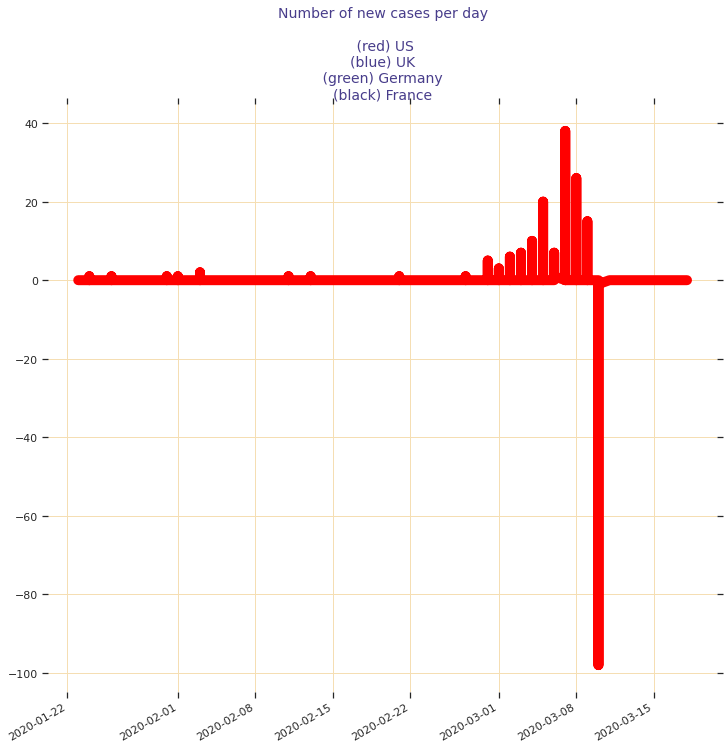

In [16]:

t = nm[(nm['Country/Region']=='US') & (nm['Province/State'].str.contains(','))]
# Adjust for extra col
t = t[t.columns[1::]]
t2=nm[nm['Country/Region']=='UK']
t3=nm[nm['Country/Region']=='Germany']
t4=nm[nm['Country/Region']=='France']



from matplotlib.ticker import FuncFormatter

fig, ax = plt.subplots(figsize=(12,12))



ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False) 


ax.plot(t['timeStamp'],t['value'],color = 'red',linewidth=10)
#ax.plot(t2['timeStamp'],t2['value'],color = 'blue')
#ax.plot(t3['timeStamp'],t3['value'],color = 'green')
#ax.plot(t3['timeStamp'],t4['value'],color = 'black')


ax.set_title("""Number of new cases per day
\n (red) US\n(blue) UK\n (green) Germany \n(black) France""", 
             fontsize=14, color='darkslateblue')


ax.grid(b=True, which='major', color='wheat', linestyle='-')


plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")  


 

fig.autofmt_xdate()
plt.show()

In [17]:

mySet = list(nm[nm['value'] > 50]['Country/Region'].drop_duplicates())

t = nm[nm['Country/Region'].isin(mySet)]
p = pd.pivot_table(t, values='value', index=['timeStamp'], columns=['Country/Region'], aggfunc=np.sum)


# 1 week intervals
pp = p.resample('7d').apply(np.sum).reset_index()
pp.head(400)

Country/Region,timeStamp,Australia,Canada,China,Cruise Ship,Denmark,France,Netherlands,US,United Kingdom
0,2020-01-22,5.0,2.0,4961.0,0.0,0.0,4.0,0.0,4.0,0.0
1,2020-01-29,8.0,2.0,18198.0,0.0,0.0,2.0,0.0,6.0,2.0
2,2020-02-05,2.0,3.0,20679.0,135.0,0.0,5.0,0.0,1.0,6.0
3,2020-02-12,0.0,1.0,29825.0,407.0,0.0,1.0,0.0,1.0,1.0
4,2020-02-19,7.0,3.0,3543.0,149.0,0.0,2.0,0.0,38.0,4.0
5,2020-02-26,17.0,19.0,2507.0,15.0,6.0,190.0,24.0,67.0,38.0
6,2020-03-04,68.0,49.0,626.0,-10.0,258.0,1588.0,358.0,841.0,333.0
7,2020-03-11,345.0,399.0,171.0,0.0,760.0,5907.0,1329.0,5462.0,1576.0
8,2020-03-18,116.0,179.0,44.0,16.0,91.0,1406.0,347.0,1362.0,682.0


In [18]:
# Deaths
nmt=pd.melt(nst, id_vars=['Country/Region'], value_vars=ns.columns[1::])



mySet = list(nmt[nmt['value'] > 1]['Country/Region'].drop_duplicates())

t = nmt[nmt['Country/Region'].isin(mySet)]
p = pd.pivot_table(t, values='value', index=['timeStamp'], columns=['Country/Region'], aggfunc=np.sum)


# 1 week intervals
pp = p.resample('7d').apply(np.sum).reset_index()
pp.head(400)

Country/Region,timeStamp,Algeria,Australia,Austria,Belgium,Brazil,Canada,China,Cruise Ship,Ecuador,Egypt,France,Germany,Greece,Iceland,Indonesia,Iran,Iraq,Italy,Japan,"Korea, South",Lebanon,Malaysia,Netherlands,Norway,Philippines,San Marino,Spain,Sweden,Switzerland,US,United Kingdom
0,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-29,0.0,0.0,0.0,0.0,0.0,0.0,360.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-02-05,0.0,0.0,0.0,0.0,0.0,0.0,621.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-02-12,0.0,0.0,0.0,0.0,0.0,0.0,891.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-02-19,0.0,0.0,0.0,0.0,0.0,0.0,662.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,10.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2020-02-26,0.0,1.0,0.0,0.0,0.0,0.0,282.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,61.0,0.0,69.0,5.0,18.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,7.0,0.0
6,2020-03-04,0.0,2.0,0.0,0.0,0.0,1.0,192.0,0.0,0.0,1.0,29.0,2.0,0.0,0.0,0.0,214.0,7.0,552.0,4.0,26.0,1.0,0.0,4.0,0.0,0.0,1.0,34.0,0.0,3.0,21.0,6.0
7,2020-03-11,4.0,2.0,3.0,10.0,1.0,4.0,91.0,1.0,2.0,3.0,115.0,22.0,5.0,1.0,5.0,697.0,4.0,1872.0,19.0,27.0,2.0,2.0,39.0,3.0,11.0,5.0,498.0,7.0,24.0,80.0,50.0
8,2020-03-18,3.0,1.0,1.0,4.0,2.0,3.0,11.0,0.0,0.0,2.0,0.0,4.0,0.0,0.0,14.0,147.0,1.0,475.0,0.0,3.0,0.0,0.0,15.0,3.0,7.0,4.0,90.0,3.0,1.0,10.0,16.0


In [19]:
nst[nst['Country/Region']=='US']

timeStamp,Country/Region,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-25 00:00:00,2020-01-26 00:00:00,2020-01-27 00:00:00,2020-01-28 00:00:00,2020-01-29 00:00:00,2020-01-30 00:00:00,2020-01-31 00:00:00,2020-02-01 00:00:00,2020-02-02 00:00:00,2020-02-03 00:00:00,2020-02-04 00:00:00,2020-02-05 00:00:00,2020-02-06 00:00:00,2020-02-07 00:00:00,2020-02-08 00:00:00,2020-02-09 00:00:00,2020-02-10 00:00:00,2020-02-11 00:00:00,2020-02-12 00:00:00,2020-02-13 00:00:00,2020-02-14 00:00:00,2020-02-15 00:00:00,2020-02-16 00:00:00,2020-02-17 00:00:00,2020-02-18 00:00:00,2020-02-19 00:00:00,2020-02-20 00:00:00,2020-02-21 00:00:00,2020-02-22 00:00:00,2020-02-23 00:00:00,2020-02-24 00:00:00,2020-02-25 00:00:00,2020-02-26 00:00:00,2020-02-27 00:00:00,2020-02-28 00:00:00,2020-02-29 00:00:00,2020-03-01 00:00:00,2020-03-02 00:00:00,2020-03-03 00:00:00,2020-03-04 00:00:00,2020-03-05 00:00:00,2020-03-06 00:00:00,2020-03-07 00:00:00,2020-03-08 00:00:00,2020-03-09 00:00:00,2020-03-10 00:00:00,2020-03-11 00:00:00,2020-03-12 00:00:00,2020-03-13 00:00:00,2020-03-14 00:00:00,2020-03-15 00:00:00,2020-03-16 00:00:00,2020-03-17 00:00:00,2020-03-18 00:00:00
143,US,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,1.0,4.0,1.0,2.0,3.0,4.0,1.0,6.0,8.0,4.0,7.0,7.0,9.0,22.0,23.0,10.0
